In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

# Specify the path to the CSV file on Google Drive
data_set = "/content/drive/MyDrive/table_hackathon_data_set_anonym.csv"

# Read the CSV file into a Pandas DataFrame
df = pd.read_csv(data_set) # 'df' contains the data from the CSV file on Google Drive

In [ ]:
# Split the data columns into multiple with one piece of information per column

import csv
import re
q1index = 8

csvfile = open('/content/drive/MyDrive/table_hackathon_data_set_anonym.csv')
outfile = open('/content/drive/MyDrive/data_clean.csv', 'w', newline='')

reader = csv.DictReader(csvfile)
headers = reader.fieldnames
n_questions = (len(headers) - q1index)//3
new_base_headers = headers[:q1index]
new_base_headers.remove("Surname")
new_base_headers.remove("First.name")
new_base_headers.remove("State")
new_headers = new_base_headers + [f'Q{i}_{tp}' for i in range(1, n_questions+1) for tp in ['seed', 'problem', 'solution', 'mistakes', 'ans', 'validity', 'score', 'prt']]

writer = csv.DictWriter(outfile, fieldnames=new_headers)
writer.writeheader()

for row in reader:
    if row['State'] != 'Finished':
        continue
    new_row = {k : row[k] for k in new_base_headers}
    for q in range(n_questions):
        i = q+1
        qtext = row[f'Question.{i}']
        qtlines = [qt for qt in qtext.splitlines() if qt]
        mistakes = []
        for j, qtline in enumerate(qtlines):
            line = re.search(r'<p>(.*)</p>', qtline).group(1)
            pieces = line.split(' - ')
            assert len(pieces) == 2
            description = pieces[0].strip()
            expression = pieces[1].strip()
            if j == 0:
                new_row[f'Q{i}_problem'] = expression
            elif j >= 2:
                mistakes.append(expression)
        new_row[f'Q{i}_mistakes'] = ';'.join(mistakes)
        new_row[f'Q{i}_solution'] = re.search(r'ans1: (.*) \[score\];', row[f'Right.answer.{i}']).group(1)
        res = row[f'Response.{i}']
        is_blank = False
        parts = res.split('; ')
        if len(parts) == 2:
            seed, prt = parts
            is_blank = True
        else:
            seed, ans, prt = parts[0], '; '.join(parts[1:-1]), parts[-1]
        new_row[f'Q{i}_seed'] = re.search(r'Seed: ([0-9]*)', seed).group(1)
        prt = re.search(r'prt1: (.*)', prt).group(1)
        new_row[f'Q{i}_prt'] = prt
        new_row[f'Q{i}_validity'] = 'blank'
        if not is_blank:
            new_row[f'Q{i}_ans'] = re.search(r'ans1: (.*) \[', ans).group(1)
            new_row[f'Q{i}_validity'] = re.search(r'ans1: .* \[(.*)\]', ans).group(1)
        if new_row[f'Q{i}_validity'] == 'score':
            score = re.search(r'# = ([0-9.]*) |', prt).group(1)
        else:
            score = 0
        new_row[f'Q{i}_score'] = score
    writer.writerow(new_row)
outfile.close()
csvfile.close()

['Username', 'Surname', 'First.name', 'State', 'Started.on', 'Completed', 'Time.taken', 'Grade.6.00', 'Question.1', 'Response.1', 'Right.answer.1', 'Question.2', 'Response.2', 'Right.answer.2', 'Question.3', 'Response.3', 'Right.answer.3', 'Question.4', 'Response.4', 'Right.answer.4', 'Question.5', 'Response.5', 'Right.answer.5', 'Question.6', 'Response.6', 'Right.answer.6']


In [ ]:
#adding indexing to the dataset
df.insert(0,'TestNo', df.index)
df['TestNo']=df['TestNo'].apply(lambda x: 'T'+str(x))

In [ ]:
#here 0 is not anticipitated and 1 is anticipitated and -1 are the values which don't need the anticipitation (as they are either empty or true or invalid)
# 0 = wrong answer and not anticipitated
# 1 = wrong answer and anticipitated
# -1 = right answer and invalid and empty
def isColumnAnticipated(row):
  if row[f'Q{i+1}_validity'] == "valid":
    return "0"
  elif row[f'Q{i+1}_validity'] == "score"  and row[f'Q{i+1}_score'] >= 0 and row[f'Q{i+1}_score'] <1:
    if row[f'Q{i+1}_prt']:
      for eachCol in row[f'Q{i+1}_prt'].split('|'):
        eachCol = eachCol.strip();
        if(eachCol[0:3]=='prt' and eachCol[-1] == 'T'):
            return "1"
      return "0"
  else:
    return "-1"

#looping over all the 6 questions and make a new column of anticipate for each of them.
for i in range(6):
  dataf = "q" + str(i+1)+"_df"
  dataf = df
  dataf[f'Q{i+1}_anticipate'] = dataf.apply(isColumnAnticipated, axis=1)
  output_file_path = "/content/drive/MyDrive/update_data_clean.csv"  # Replace with your desired output file path
  df.to_csv(output_file_path, index=False)
df.head()


,TestNo,Username,Started.on,Completed,Time.taken,Grade.6.00,Q1_seed,Q1_problem,Q1_solution,Q1_mistakes,...,Q6_ans,Q6_validity,Q6_score,Q6_prt,Q1_anticipate,Q2_anticipate,Q3_anticipate,Q4_anticipate,Q5_anticipate,Q6_anticipate
0,T0,user004,10-10-22 10:10,10-10-22 10:57,46 mins 30 secs,5.0,808626,\(\int{\frac{4}{p}} d{a}\),4*log(abs(p))+c,\({4\cdot \ln \left( \left| p\right| \right)}\),...,7/2*(x^2 - 3)^(6/7) + c,score,1.0,# = 1 | ATInt_true. | prt1-1-T,0,-1,-1,-1,-1,-1
1,T1,user004,10-10-22 14:16,10-10-22 14:35,18 mins 34 secs,3.0,490862,\(\int{\frac{10}{y}} d{a}\),10*log(abs(y))+c,\({10\cdot \ln \left( \left| y\right| \right)}\),...,(x^2 -5)^(2/3)/(2/3) +c,score,1.0,# = 1 | ATInt_true. | prt1-1-T,-1,-1,-1,0,0,-1
2,T2,user006,10-08-22 14:07,10-09-22 0:53,10 hours 45 mins,1.0,397885,\(\int{\frac{9}{r}} d{a}\),9*log(abs(r))+c,\({9\cdot \ln \left( \left| r\right| \right)}\),...,(9/2)*(x^2-4)/((2/3)*(x^2-4)^(3/2))+c,score,0.0,# = 0 | ATInt_generic. | prt1-1-F | prt1-2-F,0,0,-1,0,0,0
3,T3,user006,10-09-22 8:37,10-09-22 9:10,32 mins 59 secs,3.0,154367,\(\int{\frac{13}{t}} d{a}\),13*log(abs(t))+c,\({13\cdot \ln \left( \left| t\right| \right)}\),...,7/2*u^(6/7)+c,score,0.0,# = 0 | ATInt_generic. ATInt_var_SB_notSA. | p...,0,-1,-1,0,-1,0
4,T4,user006,10-09-22 9:15,10-09-22 9:43,28 mins 18 secs,5.0,342032,\(\int{\frac{15}{t}} d{a}\),15*log(abs(t))+c,\({15\cdot \ln \left( \left| t\right| \right)}\),...,7/6*(x^2-4)^(6/7)+c,score,1.0,# = 1 | ATInt_true. | prt1-1-T,0,-1,-1,0,-1,-1


# Giving Insight about the Dataset


In [ ]:
import matplotlib.pyplot as plt

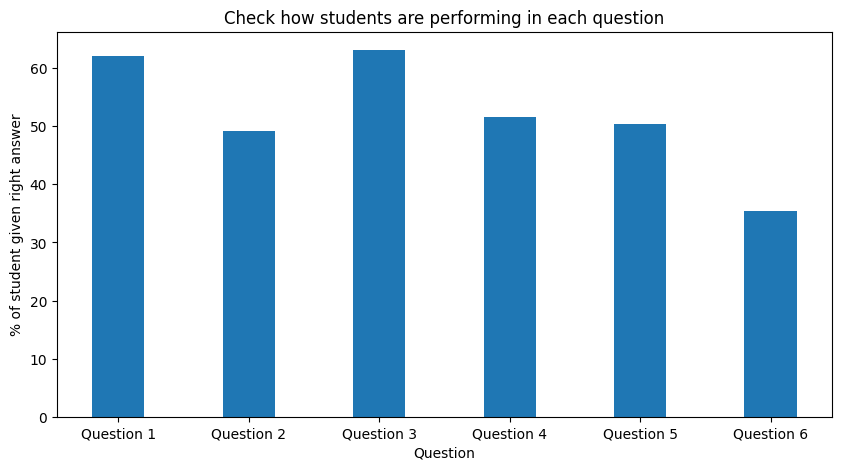

In [ ]:

data = {'Question 1':62.01456310679612, 'Question 2':49.11003236245955, 'Question 3':63.10679611650486,'Question 4':51.577669902912625,'Question 5':50.36407766990292,'Question 6':35.47734627831715}
courses = list(data.keys())
values = list(data.values())

fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(courses, values,width = 0.4)

plt.xlabel("Question")
plt.ylabel("% of student given right answer")
plt.title("Check how students are performing in each question")
plt.show()

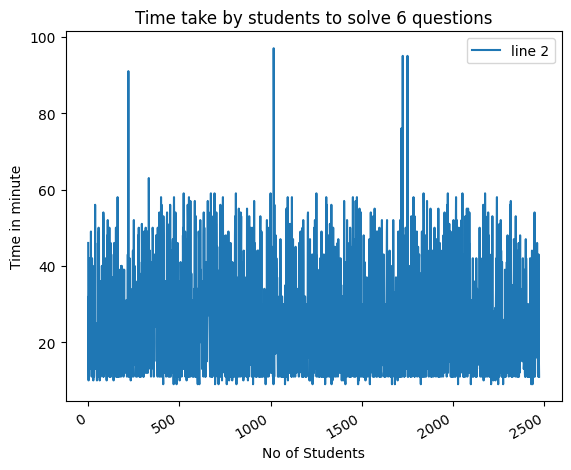

In [ ]:
#bar Graph
x2 = user
y2 = ans
# plotting the line 2 points
plt.plot(x2, y2, label = "line 2")

# naming the x axis
plt.xlabel('No of Students')
# naming the y axis
plt.ylabel('Time in minute')
# giving a title to my graph
plt.title('Time take by students to solve 6 questions')
plt.xticks(rotation=30, ha='right')
# show a legend on the plot
plt.legend()

# function to show the plot
plt.show()

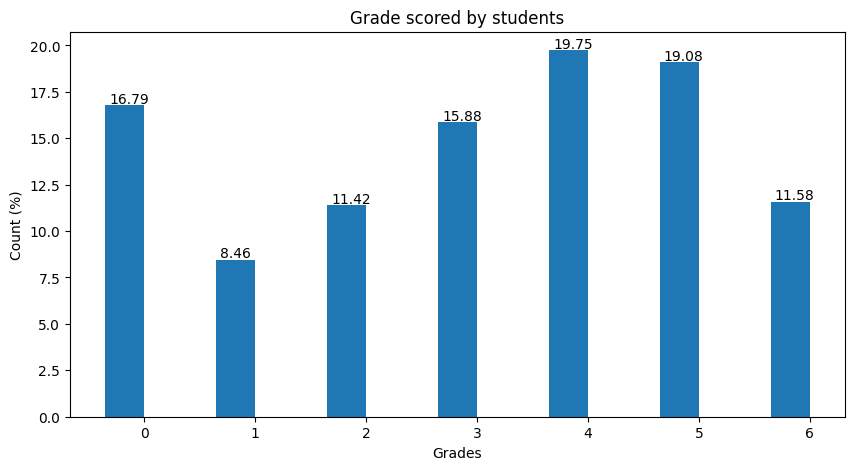

In [ ]:
import numpy as np
copydf = df.copy()
copydf['Grade'] = copydf['Grade.6.00']
var_copydf = copydf.Grade
groupGrad = []
arrgroupGrad = [0]*7
count = 2400
for i in range(len(var_copydf)):
  #print(int(a[i]))
  arrgroupGrad[int(var_copydf[i])] = arrgroupGrad[int(var_copydf[i])] + 1
  groupGrad.append(int(var_copydf[i]))

gradeValue = []
for i in range(7):
  arrgroupGrad[i] =  (arrgroupGrad[i]/count)*100
  gradeValue.append(i)


data = {gradeValue[i]: arrgroupGrad[i] for i in range(len(gradeValue))}
courses = list(data.keys())
values = list(data.values())

fig = plt.figure(figsize = (10, 5))
x = np.arange((len(gradeValue)))
width = 0.35
# creating the bar plot
#plt.bar(courses, values,width = 0.4)
pps = plt.bar(x-width/2,values,width)
for p in pps:
  height = p.get_height()
  plt.text(p.get_x()+p.get_width()/10,y=height+.10,s ="{:.2f}".format(height))

plt.xlabel("Grades")
plt.ylabel("Count (%)")
plt.title("Grade scored by students")
plt.show()